# Trading Strategy Signal

### Problem Statement

The output of a trading strategy should be able to identify if an asset is cheap/expensive/fair value, and accordingly decide the direction of a trade (buy/sell/retain). Look for price patterns and attempt to fit an algorithm to it in data mining approach. What causes these patterns is not important, only that patterns identified will continue to repeat in the future. This is a blind approach and we need rigorous checks to identify real patterns from random patterns. Use ML to create a trade signal by data mining

### What to achieve?

To identify if an asset is cheap/expensive/fair value, and accordingly decide the direction of a trade (buy/sell/retain)


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num
import datetime
import time
import os
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVR
#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode()
import IPython

In [2]:
%matplotlib inline

In [3]:
PATH=os.getcwd()
print(PATH)

/kaggle/working


# Data Loading

In [4]:
data = pd.read_csv('../input/Trading_strategy_signal.csv')

**Check the head of the data**

In [5]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,11/22/2018,219.0,219.70,214.80,215.75,215.90,967411,2099.53
1,11/21/2018,215.0,220.45,215.00,219.85,219.00,1168853,2552.75
2,11/20/2018,223.0,224.85,215.00,215.00,215.95,913551,2003.21
3,11/19/2018,222.0,225.50,221.50,224.10,224.15,904579,2022.99
4,11/16/2018,221.5,224.25,218.55,222.30,221.80,817962,1811.95


In [6]:
data.shape

(2071, 8)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 8 columns):
Date                    2071 non-null object
Open                    2071 non-null float64
High                    2071 non-null float64
Low                     2071 non-null float64
Last                    2071 non-null float64
Close                   2071 non-null float64
Total Trade Quantity    2071 non-null int64
Turnover (Lacs)         2071 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 129.5+ KB


In [8]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2.071000e+03,2071.000000
mean,150.953621,153.266659,148.504394,150.719676,150.695244,2.330422e+06,3910.091994
std,49.140708,49.916858,48.384579,49.213408,49.193064,2.084509e+06,4554.054218
min,81.100000,82.800000,80.000000,81.000000,80.950000,3.961000e+04,37.040000
25%,120.500000,122.400000,118.625000,120.400000,120.325000,1.146876e+06,1441.190000
50%,142.000000,143.950000,140.050000,141.700000,141.700000,1.773324e+06,2526.900000
75%,158.475000,160.900000,156.000000,157.775000,157.975000,2.809410e+06,4544.710000
max,327.700000,328.750000,321.650000,325.950000,325.750000,2.919102e+07,55755.080000


In [9]:
#Display the shape of the dataframe to figure out the no. of rows and columns.
print ("Dimension   : " ,data.shape)
print ("\nFeatures : \n" ,data.columns.tolist())
print ("\nMissing values :  ",data.isnull().sum().values.sum())
print ("\nUnique values :  \n",data.nunique())

Dimension   :  (2071, 8)

Features : 
 ['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity', 'Turnover (Lacs)']

Missing values :   0

Unique values :  
 Date                    2071
Open                    1191
High                    1290
Low                     1292
Last                    1300
Close                   1347
Total Trade Quantity    2070
Turnover (Lacs)         2065
dtype: int64


# Data Preprocessing - Analysis/Visualization

In [10]:
data.head(2)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,11/22/2018,219.0,219.70,214.8,215.75,215.9,967411,2099.53
1,11/21/2018,215.0,220.45,215.0,219.85,219.0,1168853,2552.75


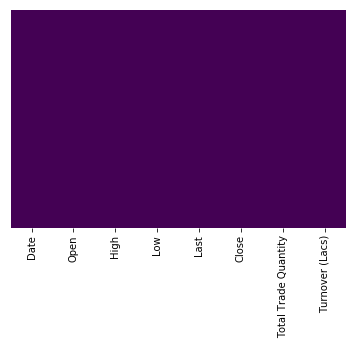

In [11]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

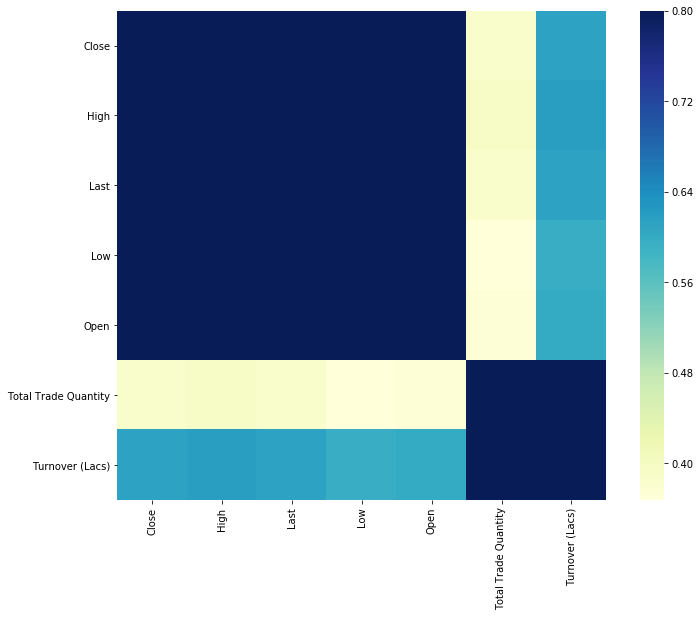

In [12]:
corrmat = data.pivot_table(index = ['Date']).corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True, cmap='YlGnBu')
plt.show()

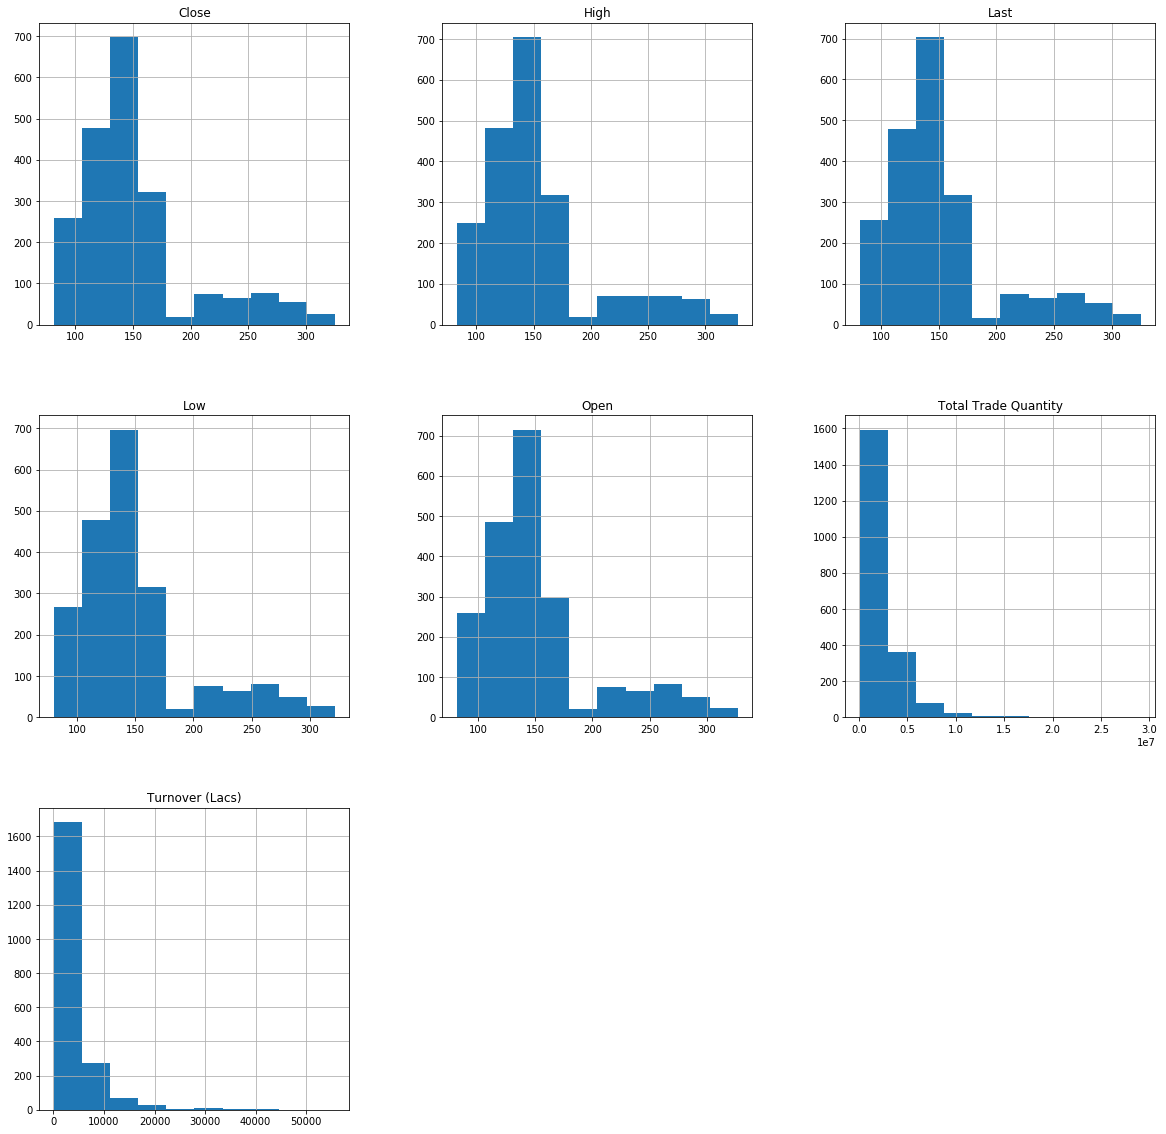

In [13]:
# Plot histogram of each parameter
data.pivot_table(index = ['Date']).hist(figsize = (20, 20)) 
plt.show()

# Checking trend of close value with the following year

In [14]:
data_list = []
for item in data['Date']:    
    date_time = datetime.datetime.strptime(item,'%m/%d/%Y')
    data_list.append(date_time)
trade_data = data.copy()

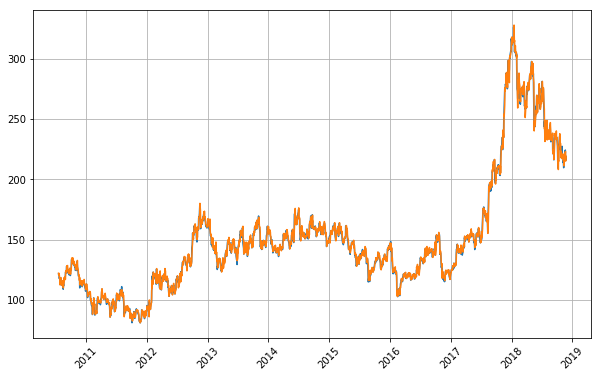

In [15]:
data['Date'] = data_list
fig = plt.figure(figsize=(10,7))
ax = plt.subplot2grid((40,40),(0,0),rowspan=40,colspan=40)
ax.plot(data['Date'], data['Close'])
ax.plot(data['Date'], data['Open'])

for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)


plt.subplots_adjust(bottom=.23)
plt.grid(True)
plt.show()

# Turnover trends in years(2010-18)

<Figure size 1440x432 with 0 Axes>

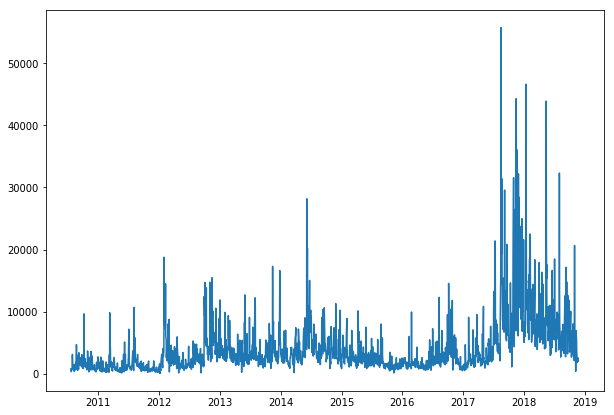

In [16]:
plt.figure(figsize=(20,6))

fig = plt.figure(figsize=(10,7))
ax = plt.subplot2grid((40,40),(0,0),rowspan=40,colspan=40)
ax.plot(data['Date'], data['Turnover (Lacs)'])

# Bollinger Band to characterize the prices and volatility over time

In [17]:
df = pd.read_csv('../input/Trading_strategy_signal.csv', index_col='Date',
                 parse_dates=True, usecols=['Date', 'Close'],
                 na_values='nan')

#Calcualting rolling average in last 20days
sma = df.rolling(window=20).mean()

In [18]:
#Standard Deviation
rstd = df.rolling(window=20).std()

In [19]:
#Upper band and Lower band of the Close value
upper_band = sma + 2 * rstd
upper_band = upper_band.rename(columns={'Close': 'upper'})
lower_band = sma - 2 * rstd
lower_band = lower_band.rename(columns={'Close': 'lower'})
lower_band.tail(5)

,lower
Date,
2010-07-27,108.469361
2010-07-26,108.420801
2010-07-23,108.389906
2010-07-22,108.276238
2010-07-21,109.014188


In [20]:
#Include Upper and lower band to the dataframe
df = df.join(upper_band).join(lower_band)

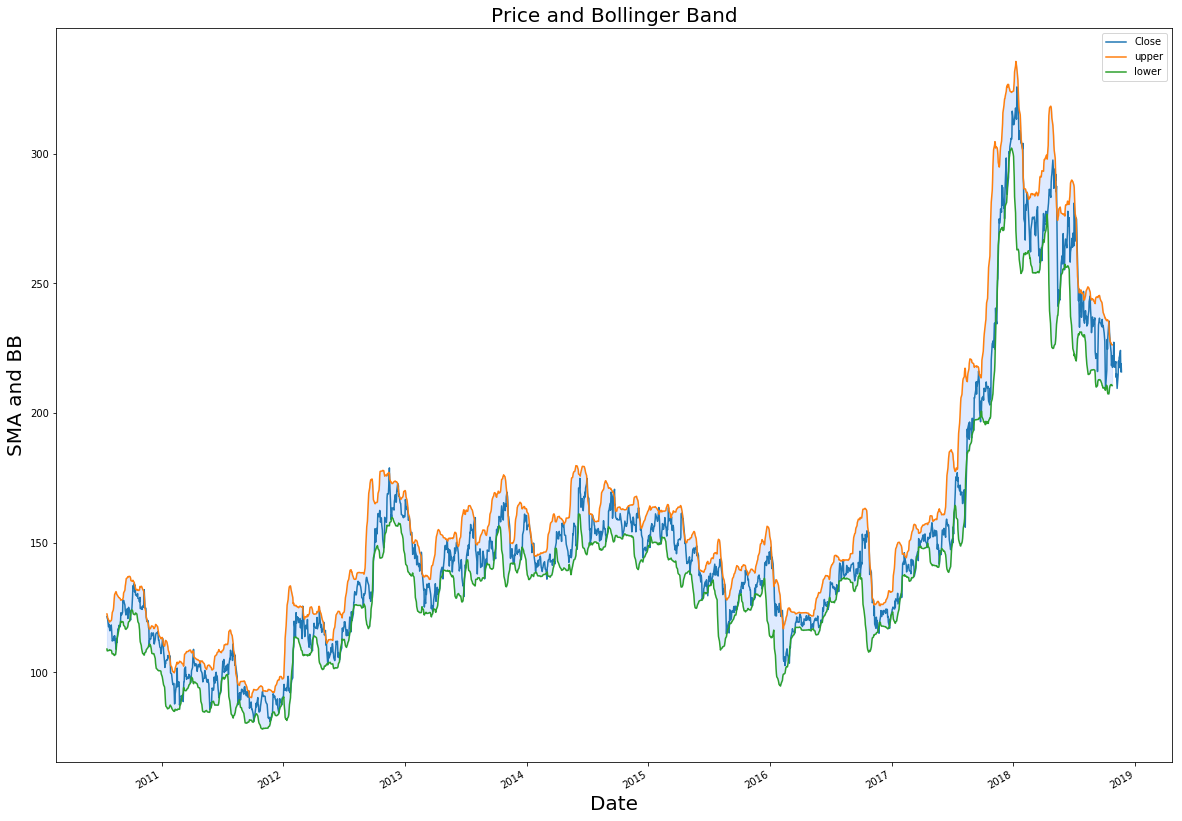

In [21]:
#Plotting the Bollinger curve
ax = df.plot(title='Price and Bollinger Band')
ax.fill_between(df.index, lower_band['lower'], upper_band['upper'], color='#ADCCFF', alpha='0.4')
ax.set_xlabel('Date')
ax.set_ylabel('SMA and BB')

fig = plt.gcf()
fig.set_size_inches(20, 15)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(20)

plt.show()


# Data preprocessing - Cleaning

In [22]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-11-22,219.0,219.70,214.80,215.75,215.90,967411,2099.53
1,2018-11-21,215.0,220.45,215.00,219.85,219.00,1168853,2552.75
2,2018-11-20,223.0,224.85,215.00,215.00,215.95,913551,2003.21
3,2018-11-19,222.0,225.50,221.50,224.10,224.15,904579,2022.99
4,2018-11-16,221.5,224.25,218.55,222.30,221.80,817962,1811.95


In [23]:
data["Date"] = pd.to_datetime(data["Date"] )

In [24]:
data.head(2)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-11-22,219.0,219.70,214.8,215.75,215.9,967411,2099.53
1,2018-11-21,215.0,220.45,215.0,219.85,219.0,1168853,2552.75


In [25]:
pd.to_datetime(data.iloc[:,0],format= "%H:%M:%S %Y-%d-%m").head(2)

0   2018-11-22
1   2018-11-21
Name: Date, dtype: datetime64[ns]

In [26]:
date = data.iloc[:,0]
date

0      2018-11-22
1      2018-11-21
2      2018-11-20
3      2018-11-19
4      2018-11-16
5      2018-11-15
6      2018-11-14
7      2018-11-13
8      2018-11-12
9      2018-11-09
10     2018-11-07
11     2018-11-06
12     2018-11-05
13     2018-11-02
14     2018-11-01
15     2018-10-31
16     2018-10-30
17     2018-10-29
18     2018-10-26
19     2018-10-25
20     2018-10-24
21     2018-10-23
22     2018-10-22
23     2018-10-19
24     2018-10-17
25     2018-10-16
26     2018-10-15
27     2018-10-12
28     2018-10-11
29     2018-10-10
          ...    
2041   2010-08-31
2042   2010-08-30
2043   2010-08-27
2044   2010-08-26
2045   2010-08-25
2046   2010-08-24
2047   2010-08-23
2048   2010-08-20
2049   2010-08-19
2050   2010-08-18
2051   2010-08-17
2052   2010-08-16
2053   2010-08-13
2054   2010-08-12
2055   2010-08-11
2056   2010-08-10
2057   2010-08-09
2058   2010-08-06
2059   2010-08-05
2060   2010-08-04
2061   2010-08-03
2062   2010-08-02
2063   2010-07-30
2064   2010-07-29
2065   201

In [27]:
data['year'] = pd.DataFrame({"year": date.dt.year})
data['month'] = pd.DataFrame({"month": date.dt.month})
data['day'] = pd.DataFrame({"day": date.dt.day})
data['dayofyear'] = pd.DataFrame({"dayofyear": date.dt.dayofyear})
data['week'] = pd.DataFrame({"week": date.dt.week})
data['weekofyear'] = pd.DataFrame({"weekofyear": date.dt.weekofyear})
data['dayofweek'] = pd.DataFrame({"dayofweek": date.dt.dayofweek})
data['weekday'] = pd.DataFrame({"weekday": date.dt.weekday})
data['quarter'] = pd.DataFrame({"quarter": date.dt.quarter})

In [28]:
data.head(2)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,2018-11-22,219.0,219.70,214.8,215.75,215.9,967411,2099.53,2018,11,22,326,47,47,3,3,4
1,2018-11-21,215.0,220.45,215.0,219.85,219.0,1168853,2552.75,2018,11,21,325,47,47,2,2,4


In [29]:
data.shape

(2071, 17)

In [30]:
data.set_index('Date', inplace=True)

In [31]:
data.head(2)

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
Date,,,,,,,,,,,,,,,,
2018-11-22,219.0,219.70,214.8,215.75,215.9,967411,2099.53,2018,11,22,326,47,47,3,3,4
2018-11-21,215.0,220.45,215.0,219.85,219.0,1168853,2552.75,2018,11,21,325,47,47,2,2,4


In [32]:
data.shape

(2071, 16)

In [33]:
data.columns

Index(['Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)', 'year', 'month', 'day', 'dayofyear', 'week',
       'weekofyear', 'dayofweek', 'weekday', 'quarter'],
      dtype='object')

# Data preprocessing - wrangling/munging

In [34]:
#Total trade quantity with respect to last 20 days average Trade quantity
data['Total Trade Quantity'] = data['Total Trade Quantity'] / data['Total Trade Quantity'].rolling(20).mean()

#Range of High minus Low value of the stock
data['Range'] = (data['High'] - data['Low'])

#Return of the stock of upcoming day(Opening to Opening)
data['Return'] = data.Open.shift(-2) - data.Open.shift(-1)

data.fillna(0, inplace=True)
data.head(5)

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,Range,Return
Date,,,,,,,,,,,,,,,,,,
2018-11-22,219.0,219.70,214.80,215.75,215.90,0.0,2099.53,2018,11,22,326,47,47,3,3,4,4.90,8.00
2018-11-21,215.0,220.45,215.00,219.85,219.00,0.0,2552.75,2018,11,21,325,47,47,2,2,4,5.45,-1.00
2018-11-20,223.0,224.85,215.00,215.00,215.95,0.0,2003.21,2018,11,20,324,47,47,1,1,4,9.85,-0.50
2018-11-19,222.0,225.50,221.50,224.10,224.15,0.0,2022.99,2018,11,19,323,47,47,0,0,4,4.00,-3.55
2018-11-16,221.5,224.25,218.55,222.30,221.80,0.0,1811.95,2018,11,16,320,46,46,4,4,4,5.70,2.60


### Data Normalization

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
sc = MinMaxScaler(feature_range= (0, 1))

In [37]:
X_norm = sc.fit_transform(data)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [38]:
X_norm

array([[0.55920519, 0.5566172 , 0.55783157, ..., 1.        , 0.13835377,
        0.61509901],
       [0.54298459, 0.5596666 , 0.55865922, ..., 1.        , 0.15761821,
        0.39232673],
       [0.57542579, 0.57755641, 0.55865922, ..., 1.        , 0.3117338 ,
        0.40470297],
       ...,
       [0.16504461, 0.15917869, 0.16656321, ..., 0.66666667, 0.0262697 ,
        0.46163366],
       [0.15896188, 0.15938199, 0.16656321, ..., 0.66666667, 0.02802102,
        0.41707921],
       [0.16626115, 0.16344786, 0.16987378, ..., 0.66666667, 0.03502627,
        0.41707921]])

In [39]:
X_norm.shape

(2071, 18)

## PCA

In [40]:
pca = PCA()

In [41]:
pca.fit_transform(X_norm)

array([[-9.01165384e-01,  7.58525331e-01,  2.24908859e-01, ...,
         1.46848925e-15,  1.86705752e-17, -4.87560578e-18],
       [-9.00153379e-01,  7.70688944e-01, -8.41642472e-03, ...,
         9.93424866e-17,  3.41934720e-18,  2.53054428e-18],
       [-8.98395664e-01,  7.94193151e-01, -2.42055384e-01, ...,
         1.12840764e-16, -3.29898320e-18, -1.02986798e-17],
       ...,
       [-1.83367484e-01, -5.13231473e-01,  4.56834324e-01, ...,
        -2.09596884e-17, -8.16410363e-18,  4.02523067e-19],
       [-1.81485815e-01, -5.12382655e-01,  2.22777847e-01, ...,
         7.18400285e-19,  1.57866549e-18,  4.15713697e-19],
       [-1.79908581e-01, -5.01786976e-01, -9.31237443e-03, ...,
        -5.94198848e-17, -5.47840491e-19,  2.23317696e-19]])

In [42]:
pca.explained_variance_ratio_

array([4.67274916e-01, 2.58184307e-01, 1.11449172e-01, 8.50614137e-02,
       3.60297686e-02, 1.82173427e-02, 7.83795977e-03, 6.74071092e-03,
       4.52351596e-03, 2.78255107e-03, 1.77456325e-03, 1.09815470e-04,
       1.03560755e-05, 2.14659985e-06, 1.46053728e-06, 2.82013176e-33,
       5.44797391e-34, 1.51202228e-35])

In [43]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

5

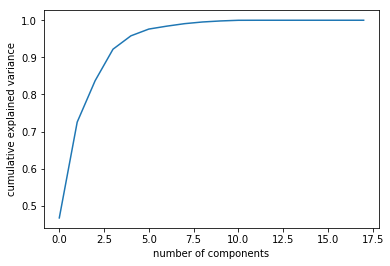

In [44]:
plt.plot(cumsum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [45]:
pca = PCA(n_components = d)

In [46]:
data['comp_1'] = pca.fit_transform(data)[:,0]
data['comp_2'] = pca.fit_transform(data)[:,1]
data['comp_3'] = pca.fit_transform(data)[:,2]
data['comp_4'] = pca.fit_transform(data)[:,3]
data['comp_5'] = pca.fit_transform(data)[:,4]

In [47]:
data.head(2)

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,Range,Return,comp_1,comp_2,comp_3,comp_4,comp_5
Date,,,,,,,,,,,,,,,,,,,,,,,
2018-11-22,219.0,219.70,214.8,215.75,215.9,0.0,2099.53,2018,11,22,326,47,47,3,3,4,4.90,8.0,-1807.984277,-139.392555,-179.790229,5.667683,0.769515
2018-11-21,215.0,220.45,215.0,219.85,219.0,0.0,2552.75,2018,11,21,325,47,47,2,2,4,5.45,-1.0,-1354.786535,-137.941546,-174.917171,4.372396,0.951383


In [48]:
# new dataset with PCA components

x_pca = data[['comp_1','comp_2','comp_3','comp_4','comp_5']]

In [49]:
x_pca.head(2)

,comp_1,comp_2,comp_3,comp_4,comp_5
Date,,,,,
2018-11-22,-1807.984277,-139.392555,-179.790229,5.667683,0.769515
2018-11-21,-1354.786535,-137.941546,-174.917171,4.372396,0.951383


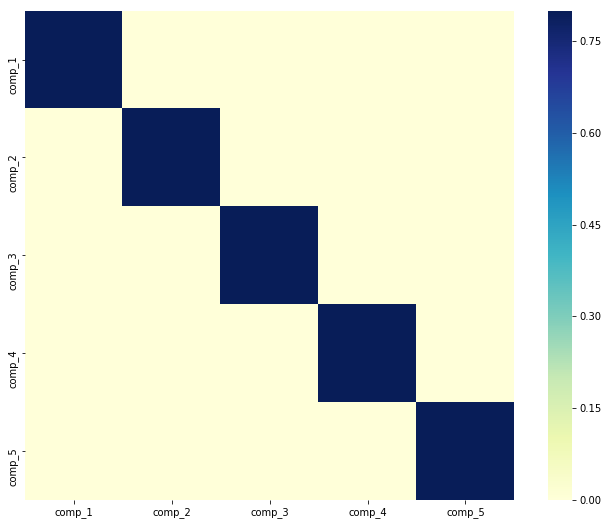

In [50]:
corrmat = x_pca.pivot_table(index = ['Date']).corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True, cmap='YlGnBu')
plt.show()

## Elbow curve

Text(0.5, 1.0, 'Elbow curve')

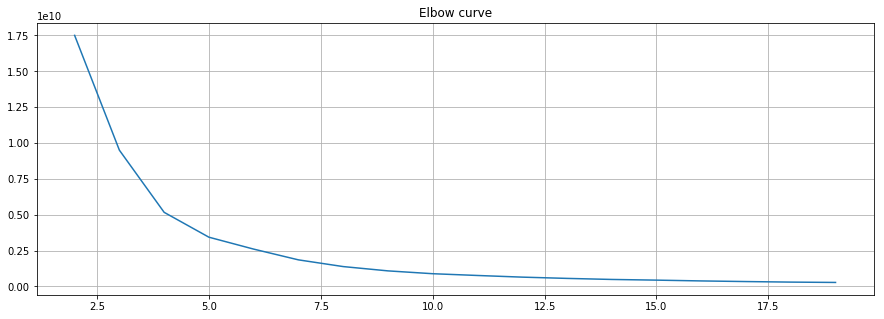

In [51]:
#Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.

distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(x_pca)
    distorsions.append(k_means.inertia_)
 
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

# K-Means Model  -------------

In [52]:
#Based on PCA components, find a target cluster

kmeans = KMeans(n_clusters = d)
data['cluster'] = kmeans.fit_predict(x_pca)

In [53]:
data.tail(2)

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,Range,Return,comp_1,comp_2,comp_3,comp_4,comp_5,cluster
Date,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-22,120.3,122.0,120.25,120.75,120.90,0.337505,355.17,2010,7,22,203,29,29,3,3,3,1.75,0.0,-3555.497227,-23.124960,14.056531,6.052481,-0.164083,0
2010-07-21,122.1,123.0,121.05,121.10,121.55,0.771274,803.56,2010,7,21,202,29,29,2,2,3,1.95,0.0,-3107.127316,-21.661086,18.641109,5.047973,-0.002424,0


## Equity Curve

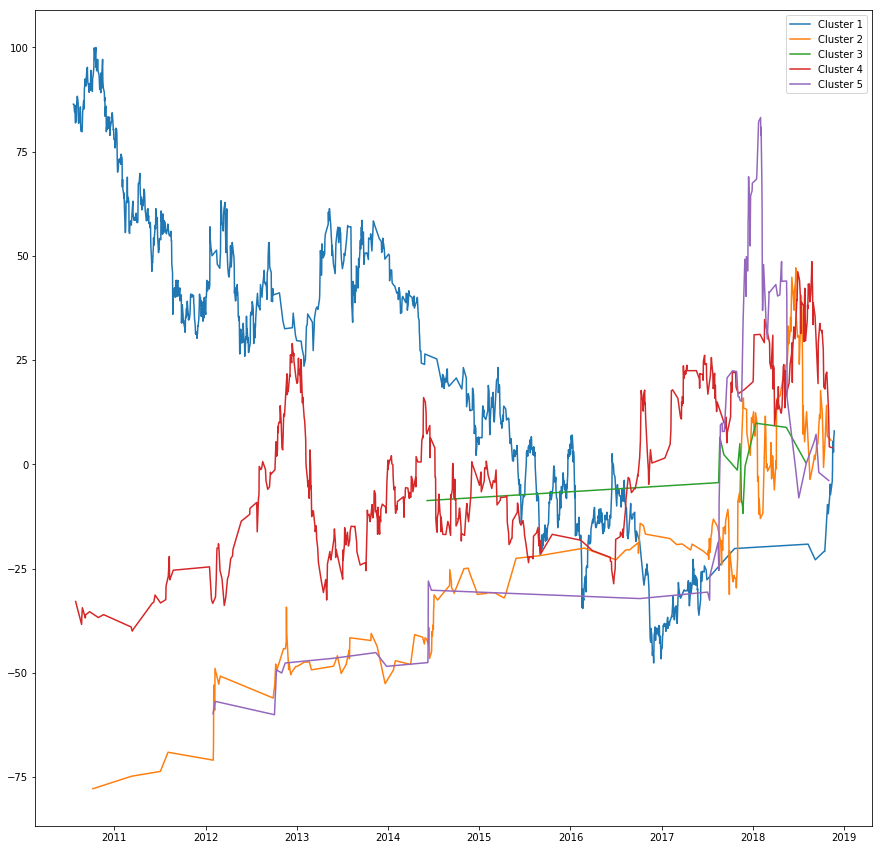

In [54]:
#Plotting an equity curve, which is a graphical representation of the change in the value of a trading account over a time period
plt.plot(np.cumsum(data['Return'].loc[data['cluster'] == 0]),label='Cluster 1')
plt.plot(np.cumsum(data['Return'].loc[data['cluster'] == 1]),label='Cluster 2')
plt.plot(np.cumsum(data['Return'].loc[data['cluster'] == 2]),label='Cluster 3')
plt.plot(np.cumsum(data['Return'].loc[data['cluster'] == 3]),label='Cluster 4')
plt.plot(np.cumsum(data['Return'].loc[data['cluster'] == 4]),label='Cluster 5')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()

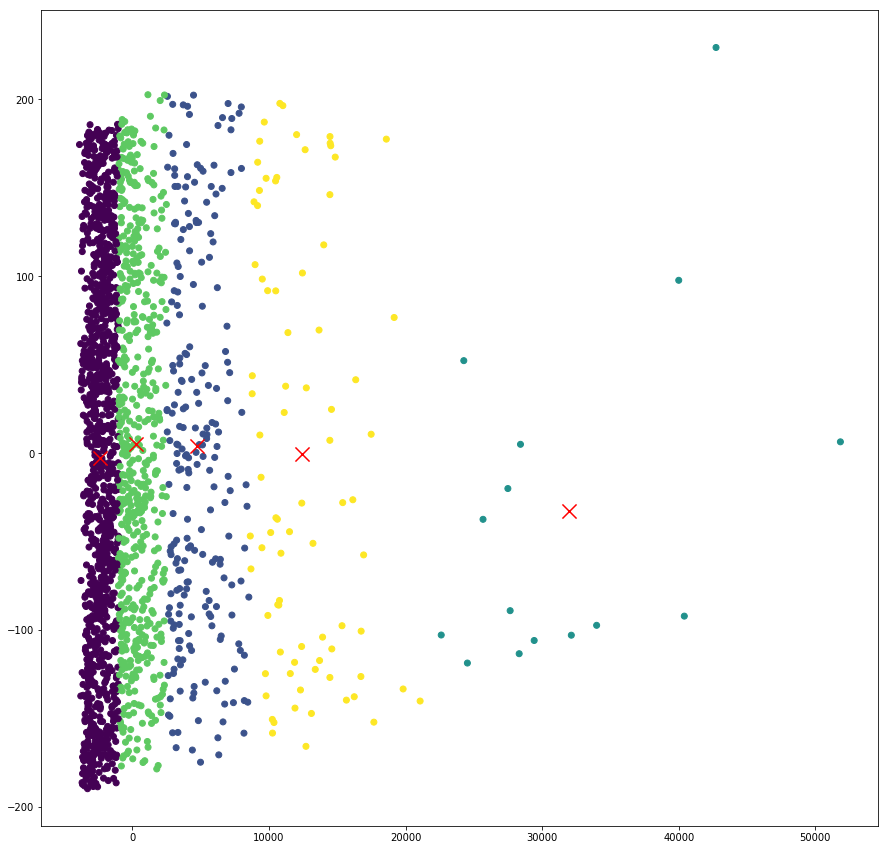

In [55]:
#Creating 6 cluster with the data as per the PCA

centers = kmeans.cluster_centers_
plt.scatter(x=data['comp_1'],y=data['comp_2'],c=data['cluster'])
plt.scatter(centers[:,0],centers[:,1],c='red',s=200,marker='x')
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()

In [56]:
#Total points Earned by Cluster Prediction
print("Total Points Earned by Cluster Prediction")

print("Cluster 1 : {}".format(round(data['Return'].loc[data['cluster'] == 0].sum(),2)))
print("Cluster 2 : {}".format(round(data['Return'].loc[data['cluster'] == 1].sum(),2)))
print("Cluster 3 : {}".format(round(data['Return'].loc[data['cluster'] == 2].sum(),2)))
print("Cluster 4 : {}".format(round(data['Return'].loc[data['cluster'] == 3].sum(),2)))
print("Cluster 5 : {}".format(round(data['Return'].loc[data['cluster'] == 4].sum(),2)))

Total Points Earned by Cluster Prediction
Cluster 1 : 86.35
Cluster 2 : -77.8
Cluster 3 : -8.7
Cluster 4 : -32.9
Cluster 5 : -59.85


In [57]:
print("Total number of records in Cluster {} are {} ".format(1, data[data.cluster == 0]["Open"].count()))
print("Total number of records in Cluster {} are {} ".format(2, data[data.cluster == 1]["Open"].count()))
print("Total number of records in Cluster {} are {} ".format(3, data[data.cluster == 2]["Open"].count()))
print("Total number of records in Cluster {} are {} ".format(4, data[data.cluster == 3]["Open"].count()))
print("Total number of records in Cluster {} are {} ".format(5, data[data.cluster == 4]["Open"].count()))
print("Total number of records in the input file = {} ".format(data.shape[0]))
print("Total number of records in all clusters  = {} ".format(data[data.cluster == 0]["Open"].count()+
                                                              data[data.cluster == 1]["Open"].count()+
                                                              data[data.cluster == 2]["Open"].count()+
                                                              data[data.cluster == 3]["Open"].count()+
                                                              data[data.cluster == 4]["Open"].count()))

Total number of records in Cluster 1 are 1167 
Total number of records in Cluster 2 are 227 
Total number of records in Cluster 3 are 15 
Total number of records in Cluster 4 are 580 
Total number of records in Cluster 5 are 82 
Total number of records in the input file = 2071 
Total number of records in all clusters  = 2071 
